In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomRotation((-6,6), fill=1),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomCrop(size=28),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])

In [3]:
train_data = datasets.MNIST(root="data", train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST(root="data",train=False, download=True, transform=test_transforms)

In [4]:
SEED =  42
cuda  = torch.cuda.is_available()
torch.manual_seed(SEED)
dataloader_args = dict(shuffle=True, batch_size= 128, num_workers=4, pin_memory=True)  if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train_data,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test_data,**dataloader_args)

In [5]:
train_iter = iter(train_loader)

In [6]:
train_batch = next(train_iter)

In [7]:
imgs, labels = train_batch

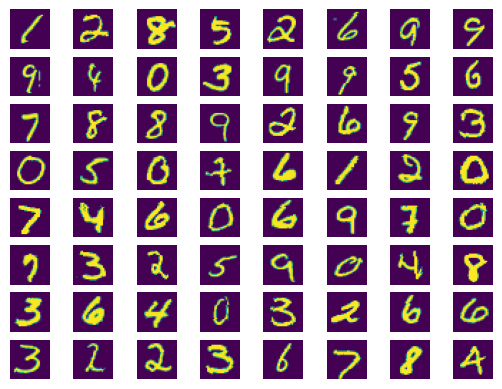

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
sub_plt = fig.subplots(8,8)
no_of_images = 64
sub_plt_imgs = imgs[0:64]
total = 0
for i in range(8):
    for j in range(8):
        sub_plt[i][j].imshow(sub_plt_imgs[total].numpy().squeeze())
        sub_plt[i][j].axis("off")
        total += 1


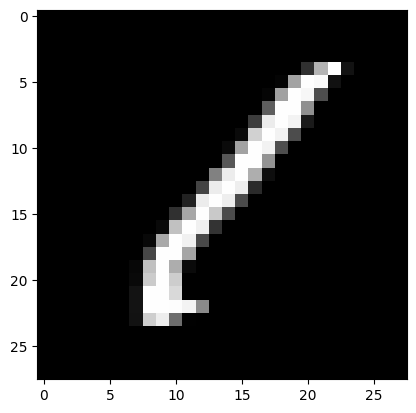

In [9]:
plt.imshow(imgs[0].numpy().squeeze(),cmap="gray")

In [10]:
from model5_1 import Model
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model().to(device)
summary(model, input_size=(1, 28, 28))


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
           Dropout-3            [-1, 8, 26, 26]               0
       BatchNorm2d-4            [-1, 8, 26, 26]              16
            Conv2d-5           [-1, 12, 24, 24]             876
              ReLU-6           [-1, 12, 24, 24]               0
           Dropout-7           [-1, 12, 24, 24]               0
       BatchNorm2d-8           [-1, 12, 24, 24]              24
            Conv2d-9           [-1, 16, 22, 22]           1,744
             ReLU-10           [-1, 16, 22, 22]               0
          Dropout-11           [-1, 16, 22, 22]               0
      BatchNorm2d-12           [-1, 16, 22, 22]              32
        MaxPool2d-13

In [11]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [12]:
from torch.optim.lr_scheduler import StepLR

model =  Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.1299629509449005 Batch_id=468 Accuracy=90.97: 100%|██████████| 469/469 [00:23<00:00, 20.01it/s]  



Test set: Average loss: 0.0508, Accuracy: 9852/10000 (98.52%)

EPOCH: 1


Loss=0.03359072282910347 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s] 



Test set: Average loss: 0.0356, Accuracy: 9906/10000 (99.06%)

EPOCH: 2


Loss=0.01752493344247341 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:23<00:00, 20.29it/s] 



Test set: Average loss: 0.0365, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.06778713315725327 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:23<00:00, 19.59it/s] 



Test set: Average loss: 0.0286, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.09654147177934647 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:23<00:00, 20.35it/s] 



Test set: Average loss: 0.0306, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.07416823506355286 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s] 



Test set: Average loss: 0.0279, Accuracy: 9911/10000 (99.11%)

EPOCH: 6


Loss=0.07841166108846664 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:23<00:00, 19.93it/s] 



Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.04803045466542244 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:23<00:00, 20.04it/s]  



Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.004975379444658756 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s] 



Test set: Average loss: 0.0240, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


Loss=0.09880157560110092 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:23<00:00, 19.88it/s]  



Test set: Average loss: 0.0233, Accuracy: 9934/10000 (99.34%)

EPOCH: 10


Loss=0.0063353776931762695 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:23<00:00, 20.12it/s]



Test set: Average loss: 0.0215, Accuracy: 9942/10000 (99.42%)

EPOCH: 11


Loss=0.020561261102557182 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s] 



Test set: Average loss: 0.0223, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.0037940379697829485 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:23<00:00, 19.84it/s]



Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.06508754193782806 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s]  



Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.036718711256980896 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:23<00:00, 19.82it/s] 



Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

